# Realign two EEGLab.Epoch object's epochs.

@Author [@FranckPrts](https://github.com/FranckPrts).

Here we attempt to provide a python-based solution to the following question: **How to can I realign concurrent epochs from two epoched object?**

Our main goal here is to be able to target all epochs in a given EEG that doesn't have a *sister* (concurently recorded) epoch in the other EEG because it was rejected by preprocessing. At the end, we should have two epoched EEG with the same amount of epochs and where each pair of epoch has their *sister* epoch at the same index.

Fist, the EEG data of each participant was segmented in 1sec epochs before moving on to preprocessing independelty each two EEG data. For each stage of this iterative process (in our case 2-3 iterations) the ID of the rejected epochs were noted in a separate file.

Our issue arise from the fact that once each step was performed, saving the data would lead to losing track of what was the epochs original IDs. 
As exemplified below: 

#IMAGE

In that process we see that an epoch that originally had the ID #6 can end up with the new ID #3. 

To retrieve the original id of the epoch, we will have to work bakward from the last iteration of preprocessing to the first iteration. At each step we will store what was the previous ID of the epochs so we can find their original IDs. 

## Imports

In [1]:
# Package 
import mne
import numpy as np
import pandas as pd
import tempfile

# Custom functions
import utils

# %matplotlib inline

We import two eeg stream that were preprocessed in MATLAB

In [2]:
def EpochsEEGLAB_to_mneEpochsFIF (path):
    """
    Loads a SET file into a mne.io.eeglab.eeglab.EpochsEEGLAB object
    and converts it into a mne.Epochs instance.

    Arguments
    ----------
    path: str
        participant #1 fNIRS data path (directory)

    Returns
    --------
    mneEpochs:
        instance of mne.Epochs.
    """
    # read the file and get a mne.io.eeglab.eeglab.EpochsEEGLAB instance
    tmp = mne.io.read_epochs_eeglab(path)

    with tempfile.TemporaryDirectory() as tmpdir:
        # save it in FIF
        tmp.save(tmpdir+"tmp.fif", overwrite=True, verbose=None)
        
    # re-read it so it is now a mne.EpochsFIF
    return mne.read_epochs(tmpdir+"tmp.fif")


In [3]:
files_to_process = np.loadtxt("files_to_process.csv",
                 delimiter=",", dtype=str)

dyad = [x for x in files_to_process]
# Careful, the file_to_process is in the order (dyad_nb, eeg_filepath_child, eeg_filepath_adutl)
dy = dyad[0]
data_path = '../FINS-data/'

In [4]:
eeg1 = EpochsEEGLAB_to_mneEpochsFIF('{}{}_{}_FP/{}'.format(data_path, dy[0], 'child', dy[1])) 
eeg2 = EpochsEEGLAB_to_mneEpochsFIF('{}{}_{}_FP/{}'.format(data_path, dy[0], 'adult', dy[2]))

Extracting parameters from /Users/zoubou/Documents/Work/NYU/Brito-Lab/FINS-Codes/../FINS-data/220_child_FP/FINS_220_Child_FreePlay_xchan_rej3.set...
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
Ready.
Reading /var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/tmpxqunwxawtmp.fif ...
    Found the data of interest:
        t =       0.00 ...     998.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated


/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_23524/2622221197.py:17: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  tmp = mne.io.read_epochs_eeglab(path)
/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_23524/2622221197.py:21: RuntimeWarning: This filename (/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/tmpxqunwxawtmp.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  tmp.save(tmpdir+"tmp.fif", overwrite=True, verbose=None)
/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_23524/2622221197.py:24: RuntimeWarning: This filename (/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/tmpxqunwxawtmp.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(tmpdir+"tmp.fif")


Extracting parameters from /Users/zoubou/Documents/Work/NYU/Brito-Lab/FINS-Codes/../FINS-data/220_adult_FP/FINS_220_Adult_FreePlay_xchan_ica_rej3.set...
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Ready.
Reading /var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/tmpjrie5mmytmp.fif ...
    Found the data of interest:
        t =       0.00 ...     998.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated


/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_23524/2622221197.py:17: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  tmp = mne.io.read_epochs_eeglab(path)
/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_23524/2622221197.py:21: RuntimeWarning: This filename (/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/tmpjrie5mmytmp.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  tmp.save(tmpdir+"tmp.fif", overwrite=True, verbose=None)
/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_23524/2622221197.py:24: RuntimeWarning: This filename (/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/tmpjrie5mmytmp.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(tmpdir+"tmp.fif")


Let's see how many epochs we have per EEG file:

In [5]:
print('EEG-1 has {} epochs.'.format(eeg1.get_data().shape[0]))
print('EEG-2 has {} epochs.'.format(eeg2.get_data().shape[0]))

EEG-1 has 159 epochs.
EEG-2 has 206 epochs.


Well, there should be the same amount of epochs in each file. Moreover, when looking at the index of each epochs (see the x-axis of the plots bellow) we can see that they are all continuous, thus, not indicating which epochs were rejected:

Using matplotlib as 2D backend.
Opening epochs-browser...


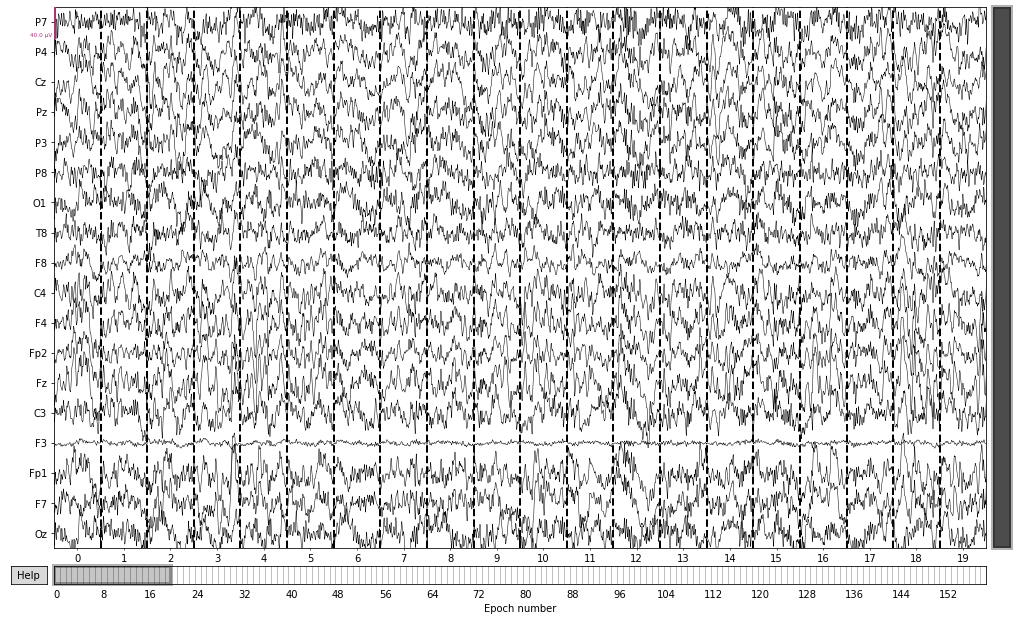

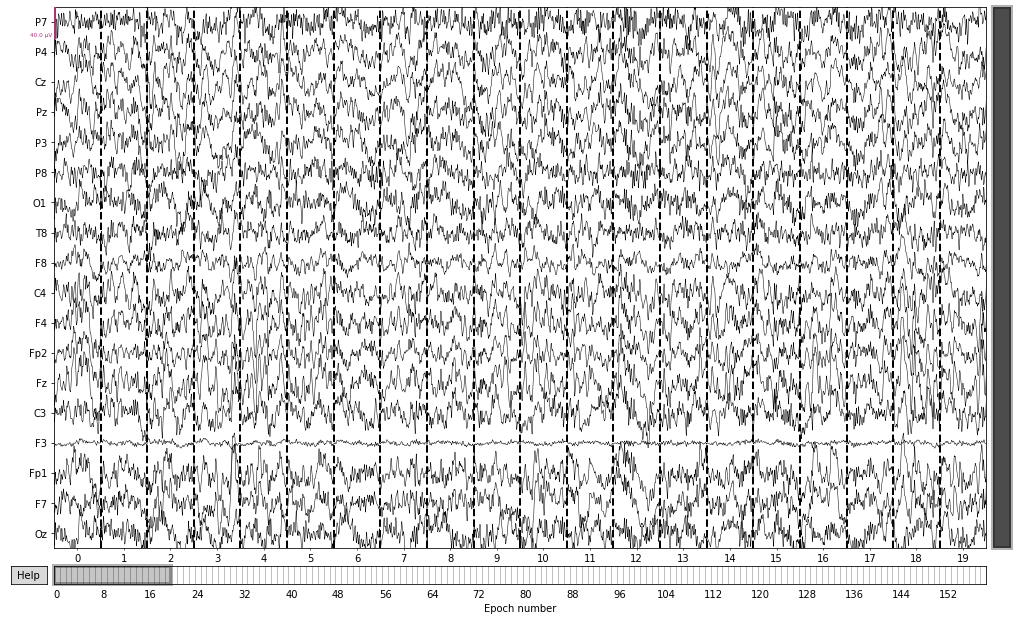

In [6]:
eeg1.plot()

Opening epochs-browser...


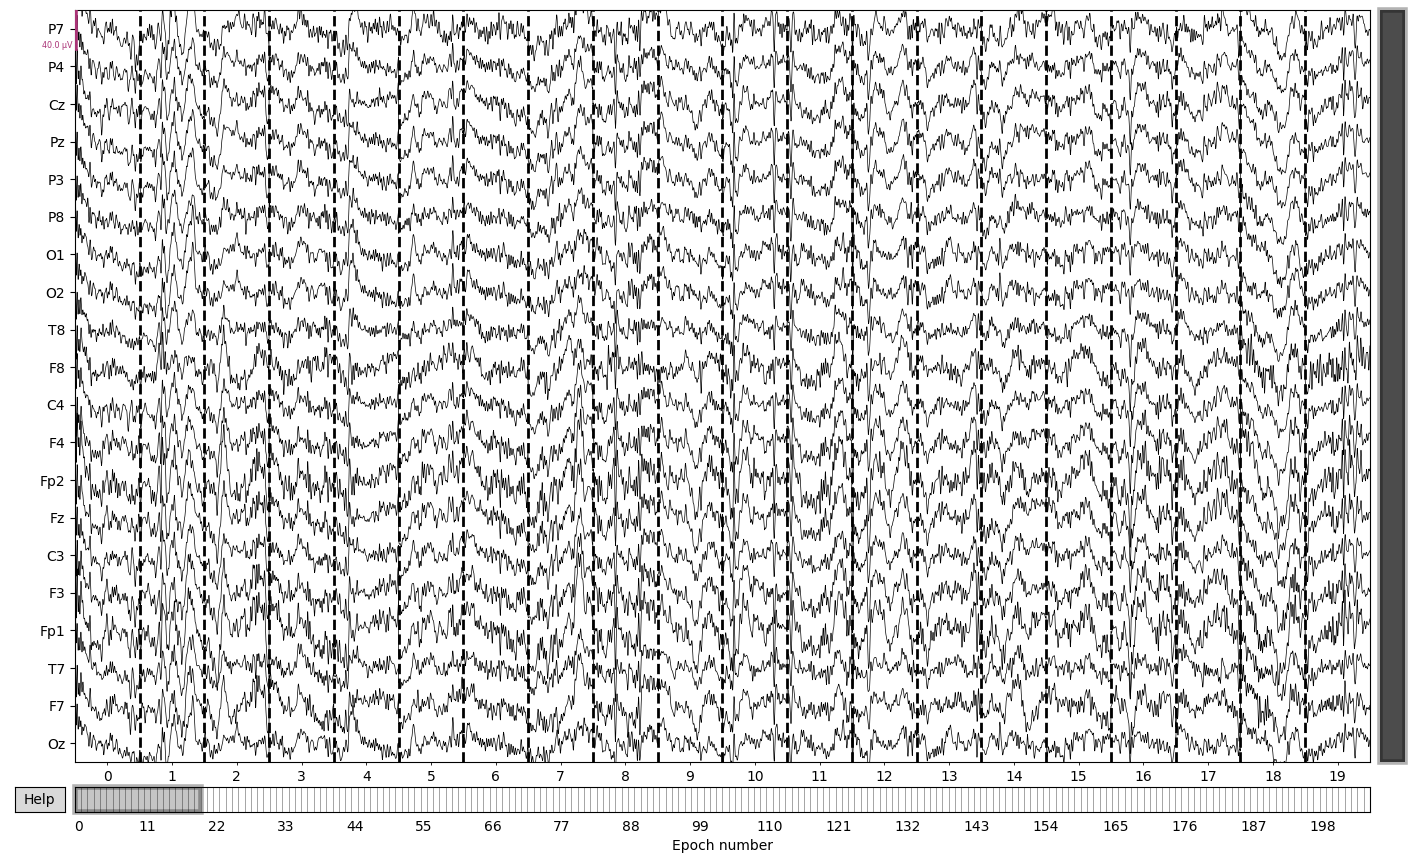

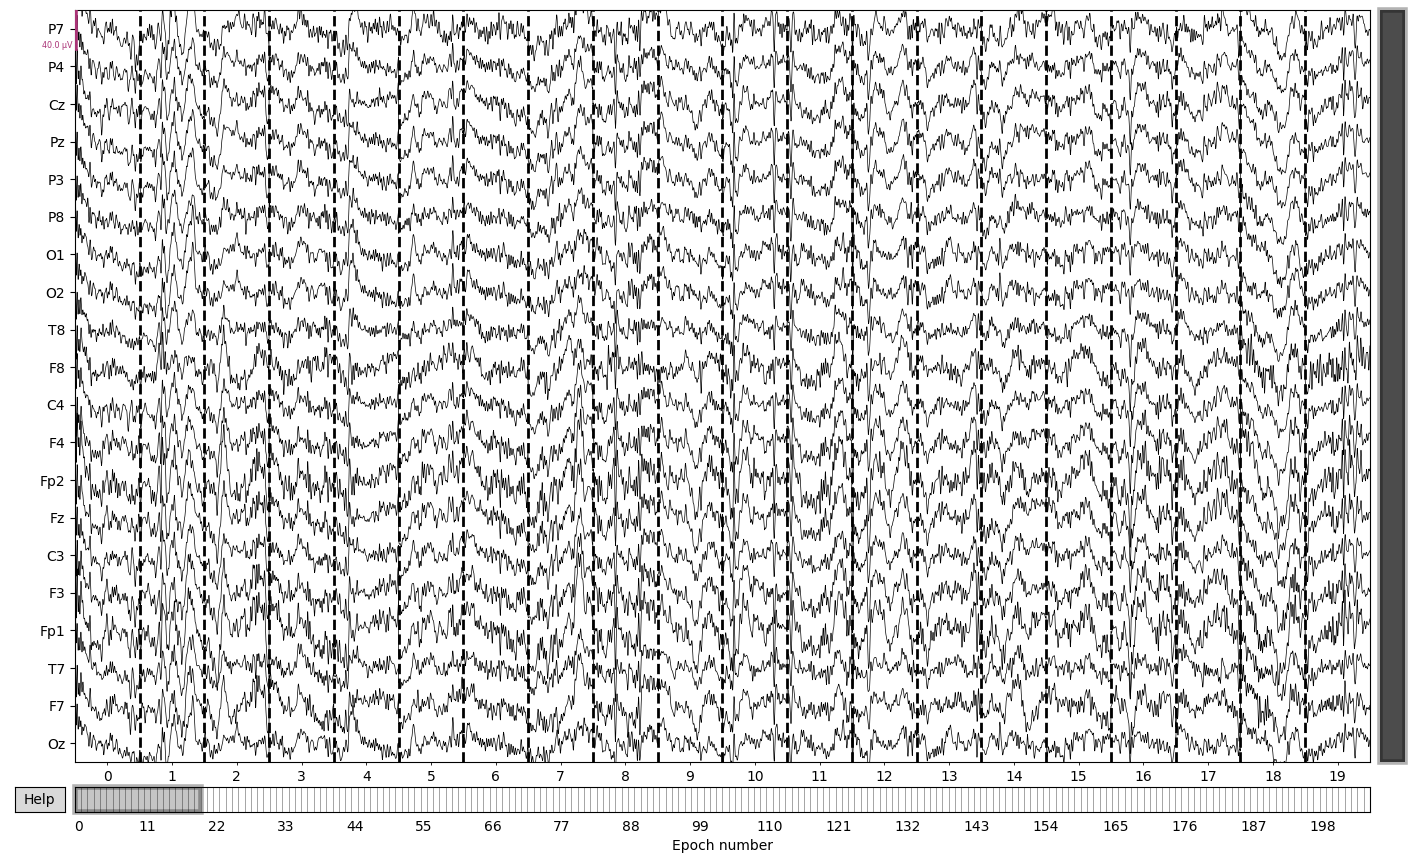

In [7]:
eeg2.plot()

### What's the plan now?

When loading an file in the EEGLAB format,  You have the following epoch indexes in your preprocessed file: 

`1, 2, 3, 4, 5, 6, 7`

And you know that the following epochs were rejected:

`3, 7, 8`

We'll now reconstruct the original epoch index as follows? (With in brackets):

`1(1), 2(2), NaN, 4(3), 5(4), 6(5), NaN, NaN, 9(6), 10(7)`


> **Careful, we have multiple round of rejection, so that method will have to be iterated over each round.**

### Extracting the epoch data

We're now going to extract the epoch data from the mne.EpochFIF to apply the operation described above.

In [10]:
df1 = eeg1.to_data_frame()
df2 = eeg2.to_data_frame()

In [15]:
eeg2.get_data().shape

(206, 20, 500)

In [26]:
df2.query('epoch == 0')


,time,condition,epoch,P7,P4,Cz,Pz,P3,P8,O1,...,C4,F4,Fp2,Fz,C3,F3,Fp1,T7,F7,Oz
0,0,1/1,0,50.007144,67.097712,74.785546,64.095482,68.746785,61.190194,58.187683,...,71.859784,79.115339,103.201126,79.280051,69.528617,70.778777,111.769425,63.853228,61.680522,54.456231
1,2,1/1,0,63.357493,74.721462,81.758160,74.186885,77.106621,68.585786,67.604153,...,78.411306,84.920699,113.596413,86.832003,77.530439,80.743721,120.006202,73.135665,70.828804,62.891782
2,4,1/1,0,72.101846,77.203621,83.228289,79.242362,80.296379,70.899892,72.118273,...,79.484791,84.687884,115.772026,88.243307,80.148579,84.591111,119.929477,77.450413,74.161452,66.580707
3,6,1/1,0,75.963124,74.808941,79.528803,79.322815,78.492790,68.413974,71.808366,...,75.443100,78.844239,110.184021,83.839767,77.610111,82.467808,112.111202,76.869096,71.849372,65.654789
4,8,1/1,0,75.252884,68.389439,71.616138,75.089795,72.470167,61.983293,67.328069,...,67.266632,68.483906,98.213914,74.644814,70.762839,75.244680,98.049532,72.049465,64.740150,60.796686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,990,1/1,0,-21.602268,-8.803831,-2.430042,-12.544837,-6.698572,-11.041024,-19.920398,...,-0.813420,7.099338,2.067687,3.493729,-5.338386,-6.266442,1.446034,-16.856238,-13.486953,-17.389485
496,992,1/1,0,-19.844252,-8.197414,-2.929153,-11.607762,-5.212659,-10.610563,-18.312435,...,-1.041181,6.128819,1.122069,2.416392,-4.513748,-6.978411,0.361878,-15.097175,-13.791617,-15.862565
497,994,1/1,0,-18.427612,-7.893837,-3.766737,-10.923816,-4.058723,-10.513751,-16.599374,...,-1.712555,4.319831,-0.846225,0.631389,-3.955769,-8.248428,-1.467320,-13.487941,-14.050410,-14.209631
498,996,1/1,0,-17.398462,-7.919489,-4.878152,-10.566254,-3.338510,-10.700125,-14.920945,...,-2.800756,1.753729,-3.767308,-1.748907,-3.730944,-9.988915,-3.850204,-12.208319,-14.222343,-12.567473


In [31]:
eeg2 = mne.from_eeglab(eeg2)
eeg3  = eeg2
modified_epochs = eeg3.from_data_frame(df2.query('epoch == 0'), eeg2.info, tmin=eeg2.tmin, tmax=eeg2.tmax)

AttributeError: module 'mne' has no attribute 'from_eeglab'

## Useful references

- To get comfortable with the MNE documentation, you should know that MNE is based on python [Object Oriented Programming (00P)](https://realpython.com/python3-object-oriented-programming/). These objects are defined from a python `Class`.
    - You can get familiarized with the OOP structure and its componenent, e.g. `methods` (a function associated to the the object) and `attribute` (a variable associated to the object), wit [this tutorial](https://www.datacamp.com/tutorial/python-oop-tutorial).
    - In MNE, we find [`Raw` objects](https://mne.tools/stable/generated/mne.io.Raw.html) (continuous data) or [`Epoch` objects](https://mne.tools/stable/generated/mne.Epochs.html) (a collection of epochs). 

You can find an introduction to the **Epochs data structure** [here](https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html) in MNE. 